In [1]:
# Import packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier ,VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV 
from sklearn import svm, datasets

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

%matplotlib inline              

In [2]:
train_data= pd.read_csv("../datasets/train.csv", index_col = 0, header=0)
test_data= pd.read_csv("../datasets/test.csv", index_col = 0, header=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Create a new copy of the data
new_data = train_data.copy()
#Divide Age and Fare into 4 groups
new_data['Fare'] = pd.cut(new_data['Fare'], 4, labels=[1, 2, 3, 4])
new_data['Age'] = pd.cut(new_data['Age'], 4, labels=[1, 2, 3, 4])

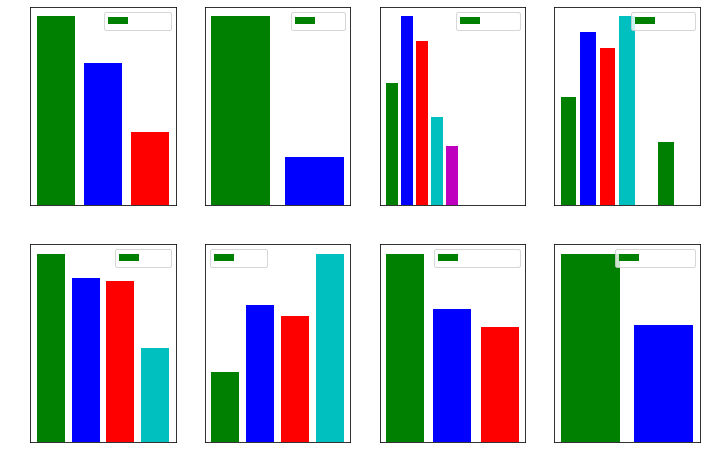

In [4]:
#Plot survival rates among groups 
columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age' ,'Fare', 'Embarked', 'Survived']
fig, ax = plt.subplots(2, 4, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
    if i ==7: 
        temp = new_data['Survived'].value_counts()/(len(new_data))
        axi.bar(temp.index, temp.values, label = columns[i], color = ['g', 'b', 'r', 'c', 'm'])
        axi.legend()
    else:    
        temp = new_data.groupby(columns[i])['Survived'].mean()
        axi.bar(temp.index, temp.values, label = columns[i], color = ['g', 'b', 'r', 'c', 'm'])
        axi.legend()

In [5]:
print(train_data.groupby('Pclass').median()['Age'])

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


In [6]:
def Titanic_data_cleaning(data):
    replace_values = data.groupby('Pclass').median()['Age'].sort_index().values
    data.loc[(data['Age'].isnull() == 1) & (data['Pclass'] == 1), 'Age'] = replace_values[0]               
    data.loc[(data['Age'].isnull() == 1) & (data['Pclass'] == 2), 'Age'] = replace_values[1]                
    data.loc[(data['Age'].isnull() == 1) & (data['Pclass'] == 3), 'Age'] = replace_values[2]                
    
    data.fillna(value = {'Fare': data['Fare'].median(), 'Embarked': data['Embarked'].mode()[0]}, 
                      inplace = True)
    data.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

    std_scaler = StandardScaler()
    data.loc[:, ['Age', 'Fare']] = std_scaler.fit_transform(data[['Age', 'Fare']])

    data = pd.get_dummies(data)
        
    return data

In [7]:
train_data = Titanic_data_cleaning(train_data)
test_data = Titanic_data_cleaning(test_data)

In [8]:
print("Train:\n",train_data.info())
print('\nTest:\n',test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    uint8  
 7   Sex_male    891 non-null    uint8  
 8   Embarked_C  891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 53.1 KB
Train:
 None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp      

In [9]:
X_train = train_data.iloc[:, 1:].copy()
y_train = train_data.iloc[:, 0].copy()
X_test = test_data.copy()

In [10]:
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=1)

In [11]:
parameters = {"n_estimators": [1, 10, 100, 250, 500, 750, 1000], 
            "max_depth": [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
            "max_features": [1, 2, 4, 6, 8, 10]}
gridsearch = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=10, scoring="accuracy", verbose=2)
gridsearch.fit(X_train, y_train)

Fitting 10 folds for each of 462 candidates, totalling 4620 fits
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END ........max_depth=1, max_features=1, n_estimators=1; total time=   0.0s
[CV] END .......max_depth=1, max_features=1, n_estimators=10; total time=   0.0s
[CV] END .......max_depth=1, max_features=1,

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'max_features': [1, 2, 4, 6, 8, 10],
                         'n_estimators': [1, 10, 100, 250, 500, 750, 1000]},
             scoring='accuracy', verbose=2)

In [12]:
gridsearch.best_score_

0.8406741573033708

1st result: 0.8339575530586767

2nd result: 0.8406741573033708